In [1]:
%pylab inline
from scipy.stats import gaussian_kde
import tensorflow as tf
from tensorflow.contrib.opt import ScipyOptimizerInterface
import pandas as pd
import simulate
from tensorflow.python.client import device_lib

print("Version: {}".format(tf.__version__))
print(device_lib.list_local_devices())

inFN = "test/big_data.csv"

Populating the interactive namespace from numpy and matplotlib


/n/home04/kmdalton/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Version: 1.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17223625448378512884
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 348061696
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 17959365787361286359
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:86:00.0, compute capability: 3.7"
]


In [2]:
I = pd.read_csv(inFN)

print("Number of reflection observations: {}".format(len(I)))
print("Multiplicity: {}".format(len(I)/len(I.groupby(['H', 'K', 'L']))))

#This removes reflections which were not observed in the 'on' and 'off' datasets at a given rotation
I = I.groupby(['H', 'K', 'L', 'RUN', 'PHINUMBER']).filter(lambda x: x.SERIES.str.contains('on').max() and x.SERIES.str.contains('off').max())

gammaobs = len(I.groupby(['H', 'K', 'L', 'RUN', 'PHINUMBER']))
gammamult = gammaobs / len(I.groupby(['H', 'K', 'L']))
print("Number of gamma observations: {}".format(gammaobs))
print("Multiplicity: {}".format(gammamult))

Number of reflection observations: 574280
Multiplicity: 8.996036781177061
Number of gamma observations: 138109
Multiplicity: 2.5422265581857673


In [3]:
"""
#########################################################
It is important to establish some numerical indices in 
order to index arrays in the optimization problem. 

----------
GAMMAINDEX
----------
    A unique numeric index is assigned to each combination
    of H, K, and L. This index uses the "MERGEDH/K/L" 
    attributes in the dataframe. This way we don't estimate
    more gammas than are truly necessary. This should not be
    used for grouping observations to make ratiometric 
    observations, because it will group together equivalent
    observations in a single image should they exist. That
    would be problematic, because equivalent observations will
    certainly not have the same partiality.

--------
RUNINDEX
--------
    A unique, sequential identifier for each run/crystal.
    Use this for indexing per crystal parameters.

----------
IMAGEINDEX
----------
    A unique, sequential identifier for each image in the 
    dataset. Use this for adding per shot parameters. 

--------
PHIINDEX
--------
    A unique, sequential identifier for each group of shots
    on the same crystal at the same rotation angle. 


#########################################################
"""

indices = {
    'GAMMAINDEX' : ['MERGEDH', 'MERGEDK', 'MERGEDL'], 
    'RUNINDEX'   : 'RUN', 
    'IMAGEINDEX' : ['RUN', 'PHINUMBER', 'SERIES'],
    'PHIINDEX'   : ['RUN', 'PHINUMBER'],
}

for k,v in indices.items():
    I[k] = I.groupby(v).ngroup()

In [4]:
k = [i for i in I if 'ipm' in i.lower()]
k += ['RUNINDEX', 'Io']
imagemetadata = I[k + ['IMAGEINDEX']].groupby('IMAGEINDEX').mean()
imagemetadata 

,IPM_0,IPM_1,IPM_2,IPM_3,IPM_X,IPM_Y,IPM,RUNINDEX,Io
IMAGEINDEX,,,,,,,,,
0,0.782384,0.495686,0.783506,0.498735,-0.003066,-0.000717,2.560311,0,2.560311
1,0.534010,0.339646,0.533455,0.338238,0.002077,0.000520,1.745348,0,1.745348
2,0.455588,0.289014,0.455691,0.289684,-0.001158,-0.000113,1.489977,0,1.489977
3,2.561312,1.628945,2.565890,1.627089,0.000570,-0.000893,8.383236,0,8.383236
4,0.758740,0.482631,0.757830,0.480454,0.002261,0.000600,2.479655,0,2.479655
5,0.539087,0.343386,0.539897,0.341825,0.002278,-0.000751,1.764195,0,1.764195
6,0.522285,0.332798,0.523069,0.331057,0.002623,-0.000750,1.709208,0,1.709208
7,0.229693,0.145490,0.229460,0.146090,-0.002057,0.000509,0.750733,0,0.750733
8,0.245974,0.155906,0.245634,0.156290,-0.001228,0.000690,0.803804,0,0.803804


In [5]:
iobs        = I.pivot_table(values='IOBS', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'], columns='SERIES', fill_value=np.NaN) 
imagenumber = I.pivot_table(values='IMAGEINDEX', index=['H', 'K', 'L', 'RUNINDEX', 'PHIINDEX'], columns='SERIES', fill_value=-1)
gammas = iobs[[i for i in iobs if 'on' in i]].sum(1) / iobs[[i for i in iobs if 'off' in i]].sum(1)


gammaidx = I.pivot_table(values='GAMMAINDEX', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'])
gammaidx = np.array(gammaidx).flatten()


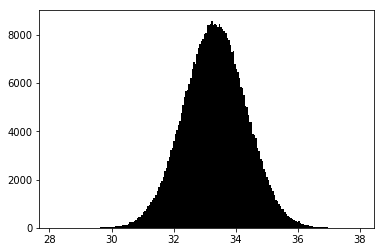

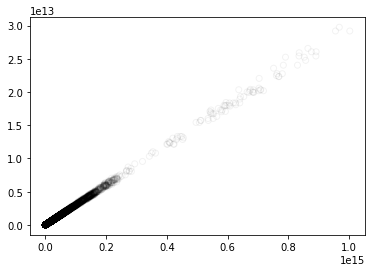

In [18]:
_=plt.hist(I['IOBS']/I['SIGMA(IOBS)'], 200, color='k')

plt.figure()
plt.scatter(I['IOBS'], I['SIGMA(IOBS)'], edgecolors='k', facecolors='none', alpha=0.05)

In [6]:
tf.reset_default_graph()
h = gammaidx.max() + 1

r = len(gammas.reset_index().groupby('RUNINDEX'))
runidx = np.array(imagemetadata['RUNINDEX'])

#We need two sparse tensors to map from Icryst estimates into the liklihood function. 
#First the 'on' shots
tmp = np.array(imagenumber[[i for i in imagenumber if 'on' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
onimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(imagemetadata)))
onimageidx = tf.sparse_reorder(onimageidx)

#Now the 'off' shots
tmp = np.array(imagenumber[[i for i in imagenumber if 'off' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
offimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(imagemetadata)))
offimageidx = tf.sparse_reorder(offimageidx)

#Let us have a sparse matrix for averaging hkl observations
idx = np.vstack((
    gammaidx,
    np.arange(len(gammaidx), dtype=int), 
)).T
tshape = (
    gammaidx.max()+1,
    len(gammaidx), 
)
vals = np.array(1./np.bincount(gammaidx)[gammaidx], dtype=float32)
mergingtensor = tf.SparseTensor(idx, vals, tshape)
mergingtensor = tf.sparse_reorder(mergingtensor)



#Constants 
raw_gammas = tf.constant(np.float32(gammas))
ipm        = tf.constant(np.float32(imagemetadata['Io']))
ipm_x      = tf.constant(np.float32(imagemetadata['IPM_X']))
ipm_y      = tf.constant(np.float32(imagemetadata['IPM_Y']))

#Regularization strength
#rho = tf.placeholder(tf.float32)

#LCs for scaling IPM data
x_slope_ = 5000.
x_intercept   = tf.constant(imagemetadata.IPM_X.mean())
x_slope       = tf.constant(1./imagemetadata.IPM_X.std())
y_intercept   = tf.constant(imagemetadata.IPM_Y.mean())
y_slope       = tf.constant(1./imagemetadata.IPM_Y.std())
#ipm_slope     = tf.Variable(1.)
ipm_slope     = tf.constant(1.)
ipm_intercept = tf.Variable(0.)
#ipm_intercept = tf.constant(0.)

#Beam shape
#sigx          = tf.Variable(10.*(2**0.5))
sigx          = tf.constant(50.)
sigy          = tf.constant(50.)

#Crystal dimensions
xmin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
xmax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))
ymin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
ymax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))

#gammastimates
gamma         = tf.Variable(np.ones(h), dtype=np.float32)

beamx  = ipm_x * x_slope + x_intercept
beamy  = ipm_y * y_slope + y_intercept


Icryst = 0.25*(ipm_slope*ipm + ipm_intercept) * (
    tf.erf((tf.gather(xmin, runidx) - beamx)/sigx) - tf.erf((tf.gather(xmax, runidx) - beamx)/sigx)
    ) * (
    tf.erf((tf.gather(ymin, runidx) - beamy)/sigy) - tf.erf((tf.gather(ymax, runidx) - beamy)/sigy)
    )

Bon  = tf.squeeze(tf.sparse_tensor_dense_matmul( onimageidx, tf.expand_dims(Icryst, 1)))
Boff = tf.squeeze(tf.sparse_tensor_dense_matmul(offimageidx, tf.expand_dims(Icryst, 1)))


#g = tf.maximum(raw_gammas*Boff/Bon, 0.)
g = raw_gammas*Boff/Bon
#deltaF = tf.sqrt(g) - 1.
deltaF_unmerged = (tf.sqrt(g) - 1.)
deltaF = tf.squeeze(tf.sparse_tensor_dense_matmul(mergingtensor, tf.expand_dims(deltaF_unmerged, 1)))
loss = tf.reduce_sum(tf.abs(deltaF))



"""
absolute_deviation = (1./len(gammaidx))* \
    tf.reduce_sum(tf.abs(
            tf.square(tf.gather(gamma, gammaidx)) * tf.squeeze(Bon / Boff) 
        ) - raw_gammas
    ))
"""

#regularizer = (1./h)*tf.reduce_sum(tf.abs(gamma - 1.))

#loss = (1. - rho)*absolute_deviation + rho*regularizer

'\nabsolute_deviation = (1./len(gammaidx))*     tf.reduce_sum(tf.abs(\n            tf.square(tf.gather(gamma, gammaidx)) * tf.squeeze(Bon / Boff) \n        ) - raw_gammas\n    ))\n'

0: 2729.177734375
10: 1267.3883056640625
20: 1267.1748046875
30: 1266.959228515625
40: 1266.7362060546875
50: 1266.50439453125
60: 1266.258056640625
70: 1266.0009765625
80: 1265.7314453125
90: 1265.4542236328125
100: 1265.1724853515625
110: 1264.900390625
120: 1264.628173828125
130: 1264.3603515625
140: 1264.1014404296875
150: 1263.8671875
160: 1263.638427734375
170: 1263.4112548828125
180: 1263.18798828125
190: 1262.9754638671875
200: 1262.7691650390625
210: 1262.57177734375
220: 1262.380859375
230: 1262.19384765625
240: 1262.015380859375
250: 1261.841552734375
260: 1261.6689453125
270: 1261.496826171875
280: 1261.32763671875
290: 1261.16650390625
300: 1261.007080078125
310: 1260.8499755859375
320: 1260.694091796875
330: 1260.5430908203125
340: 1260.3983154296875
350: 1260.26025390625
360: 1260.125732421875
370: 1259.999755859375
380: 1259.8812255859375
390: 1259.7647705078125
400: 1259.6527099609375
410: 1259.54345703125
420: 1259.4415283203125
430: 1259.3453369140625
440: 1259.25085

No handles with labels found to put in legend.


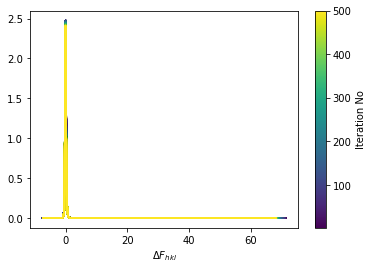

<Figure size 432x288 with 0 Axes>

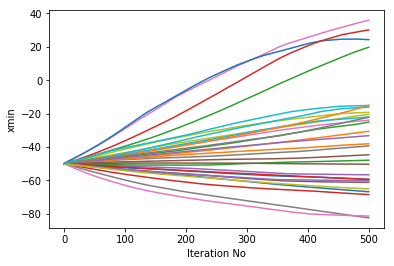

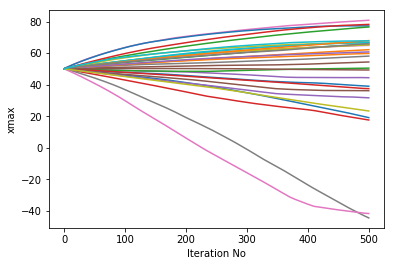

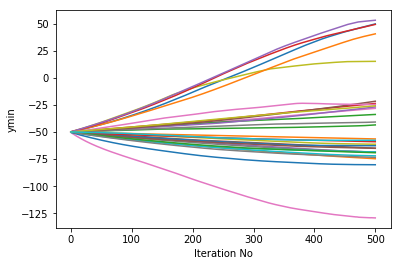

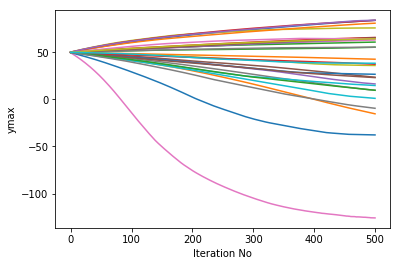

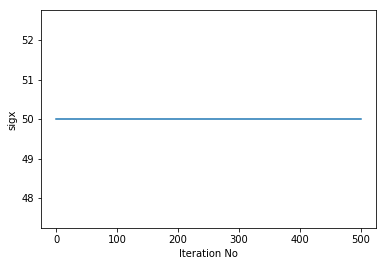

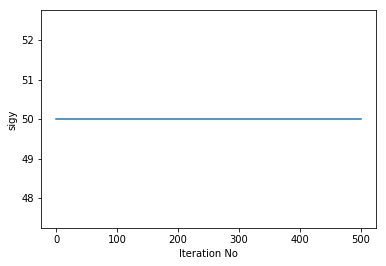

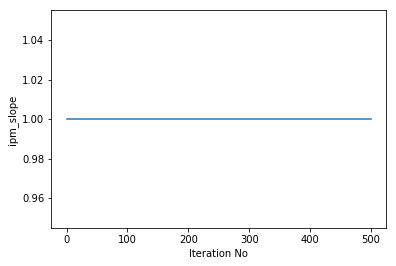

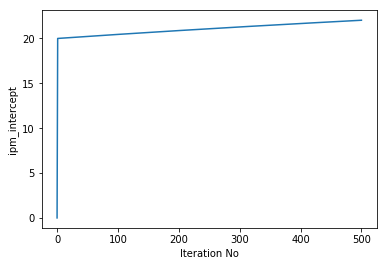

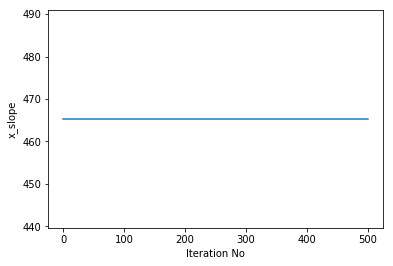

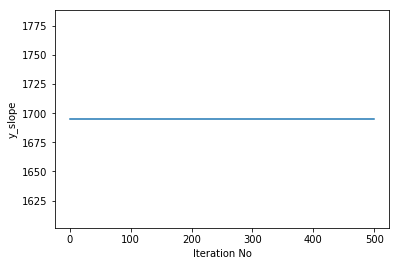

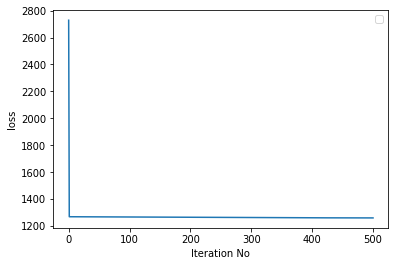

In [7]:
var_groups = {
    'IPM Slope'     : [ipm_slope, ipm_intercept],
    'Beam Shape'    : [sigx, sigy], 
    'Beam Position' : [x_slope, x_intercept, y_slope, y_intercept], 
    'Crystal Dimensions' : [xmin, xmax, ymin, ymax], 
}

#optimizers = {k:tf.train.AdagradOptimizer(1e-10).minimize(loss, var_list=v) for k,v in var_groups.items()}

#optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
optimizer = tf.train.AdagradOptimizer(20.).minimize(loss)
#optimizer = tf.keras.optimizers.SGD(0.1).minimize(loss)

tf.gradients


nsteps = 500
verbose=False
cmap = plt.get_cmap()
norm = plt.Normalize(vmin=1., vmax=nsteps)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array((1., nsteps))



logvars = {
    'xmin': xmin,
    'xmax': xmax,
    'ymin': ymin,
    'ymax': ymax,
    'sigx': sigx,
    'sigy': sigy,
    'Icryst': Icryst,
    'ipm_slope' : ipm_slope, 
    'x_slope' : x_slope, 
    'y_slope' : y_slope, 
    'gamma' : g,
    'deltaF unmerged': deltaF_unmerged,
    'deltaF' : deltaF,
    'ipm_intercept' : ipm_intercept, 
    'loss' : loss,
    #'regularizer' : regularizer,
    #'absolute_deviation' : absolute_deviation,
}

L = {k:[] for k in logvars}
#L['loss'] = []
deltaF_ = None
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for k,v in logvars.items():
        L[k].append(sess.run(v))
    print("0: {}".format(L['loss'][-1]))
    for i in range(nsteps):
        _,loss_ = sess.run((optimizer, loss))
        for k,v in logvars.items():
            L[k].append(sess.run(v))
        if np.isnan(L['loss'][-1]):
            break
        #print("{}: {}".format(i+1, L['loss'][-1]))
        if (i + 1) % 10 == 0:
            print("{}: {}".format(i+1, L['loss'][-1]))
        deltaF_ = sess.run(deltaF)
        x1, x2  = deltaF_.min(),deltaF_.max()
        X = np.linspace(x1 - 0.1*(x2 - x1), x2 + 0.1*(x2 - x1), 200)
        plt.plot(X, gaussian_kde(deltaF_)(X), c=sm.to_rgba(i+1))
        
        

plt.colorbar(sm, ax=plt.gca(), label='Iteration No')
plt.xlabel('$\Delta F_{hkl}$')

plotvars = ['xmin', 'xmax', 'ymin', 'ymax', 'sigx', 'sigy', 'ipm_slope', 'ipm_intercept', 'x_slope', 'y_slope', 'loss']

plt.figure()
for k in plotvars:
    v = L[k]
    plt.figure()
    plt.plot(v)
    plt.ylabel(k)
    plt.xlabel('Iteration No')
plt.legend()

Text(0,0.5,'$Crystal\\ \\hat X_{max}$')

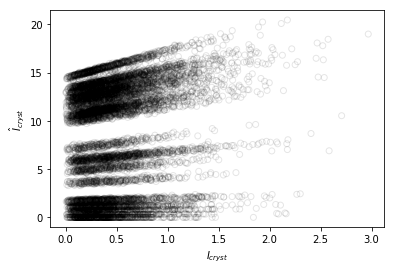

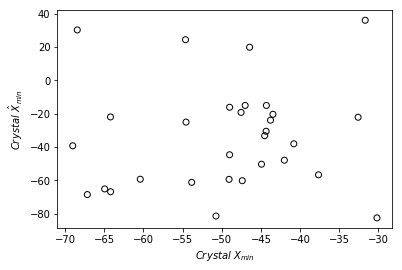

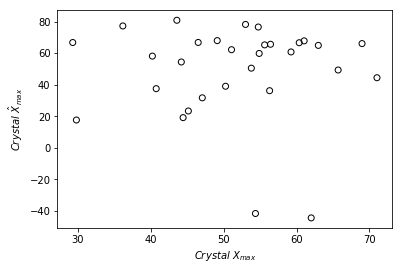

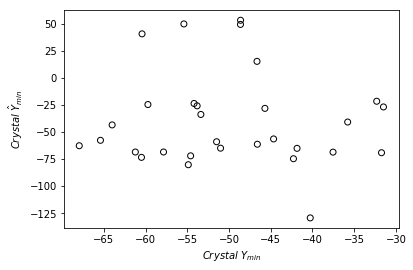

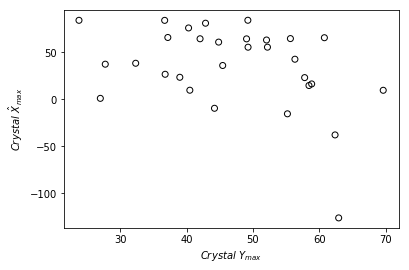

In [8]:
#How well is this doing at inferring parameters?
plt.scatter(I.groupby("IMAGEINDEX").mean()['Icryst'], L['Icryst'][-1], facecolors='none', edgecolors='k', alpha=0.1)
plt.xlabel(r"$I_{cryst}$")
plt.ylabel(r"$\hat I_{cryst}$")


plt.figure()
scatter(I.groupby("RUNINDEX").mean()['CRYSTLEFT'], L['xmin'][-1], facecolors='none', edgecolors='k')
plt.xlabel("$Crystal\ X_{min}$")
plt.ylabel("$Crystal\ \hat X_{min}$")

plt.figure()
scatter(I.groupby("RUNINDEX").mean()['CRYSTRIGHT'], L['xmax'][-1], facecolors='none', edgecolors='k')
plt.xlabel("$Crystal\ X_{max}$")
plt.ylabel("$Crystal\ \hat X_{max}$")

plt.figure()
scatter(I.groupby("RUNINDEX").mean()['CRYSTBOTTOM'], L['ymin'][-1], facecolors='none', edgecolors='k')
plt.xlabel("$Crystal\ Y_{min}$")
plt.ylabel("$Crystal\ \hat Y_{min}$")

plt.figure()
scatter(I.groupby("RUNINDEX").mean()['CRYSTTOP'], L['ymax'][-1], facecolors='none', edgecolors='k')
plt.xlabel("$Crystal\ Y_{max}$")
plt.ylabel("$Crystal\ \hat X_{max}$")

(-100, 100)

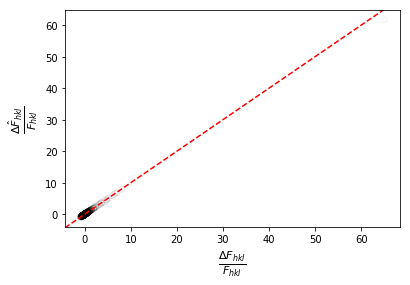

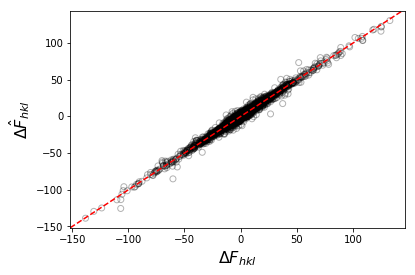

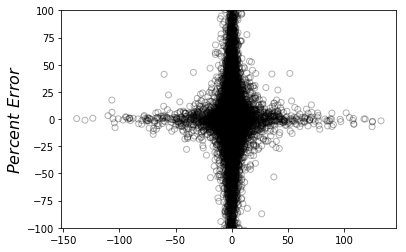

In [14]:
#deltaF_ = L['deltaF']
truegammas = np.array(I.groupby('GAMMAINDEX').mean()['gamma'])
trueFoff   = np.array(I.groupby('GAMMAINDEX').mean()['Foff'])
truedeltaF = trueFoff*(np.sqrt(truegammas) - 1)

deltaF_estimate = trueFoff*deltaF_

plt.scatter(truedeltaF/trueFoff, deltaF_, edgecolors='k', facecolors='none', alpha=0.05)
plt.xlabel(r'$\frac{\Delta F_{hkl}} {F_{hkl}}$', fontsize=16)
plt.ylabel(r'$\frac{\Delta \hat F_{hkl}} {F_{hkl}}$', fontsize=16)
xlim = plt.xlim()
ylim = plt.ylim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, x, '--r')
plt.xlim(xlim)
plt.ylim(ylim)

plt.figure()
plt.scatter(truedeltaF, deltaF_estimate, edgecolors='k', facecolors='none', alpha=0.3)
plt.xlabel(r'$\Delta F_{hkl} $', fontsize=16)
plt.ylabel(r'$\Delta \hat F_{hkl} $', fontsize=16)
xlim = plt.xlim()
ylim = plt.ylim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, x, '--r')
plt.xlim(xlim)
plt.ylim(ylim)

plt.figure()
x = np.sort(truedeltaF), 
y = (100.*(deltaF_estimate - truedeltaF)/truedeltaF)[np.argsort(truedeltaF)]
plt.scatter(np.sort(truedeltaF), (100.*(deltaF_estimate - truedeltaF)/truedeltaF)[np.argsort(truedeltaF)], color='k', facecolors='none', edgecolors='k', alpha=0.3)
plt.ylabel(r'$Percent\ Error$', fontsize=16)
plt.ylim(-100, 100)


In [10]:
outFN = "test/1ubq_deltaFestimate.hkl"
phaseFN = "test/1ubq.pdb.hkl"

from importlib import reload
import crystal
reload(crystal)

x = crystal.crystal().read_hkl(phaseFN)

H = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDH'], dtype=int)
K = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDK'], dtype=int)
L = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDL'], dtype=int)

header = """{{ sg=P2(1)2(1)2(1) a=50.84 b=42.77 c=28.95 alpha=90 beta=90 gamma=90 }}
NREFlections={}
ANOMalous=FALSE
DECLare NAME=FOBS DOMAin=RECIprocal TYPE=COMPLEX END
""".format(len(deltaF_estimate))

with open(outFN, 'w') as out:
    out.write(header)
    for h,k,l,f in zip(H, K, L, deltaF_estimate):
        p = x.loc[h, k, l]['PHASE']
        out.write("INDE {} {} {} FOBS= {} {}\n".format(h,k,l,f,p))